This notebook covers the early phases of **Task 1**:  
1. Data loading & inspection  
2. Cleaning  
3. EDA & class imbalance analysis  
4. Feature engineering (initial)  
5. Handling imbalanced data  

In [12]:
# Import core libraries
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

# Imbalance handling
from imblearn.over_sampling import SMOTE

# Display settings
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8')



In [3]:
# Filepaths (update if needed)
fraud_path = "../data/raw/Fraud_Data.csv"
ip_map_path = "../data/raw/IpAddress_to_Country.csv"
credit_path = "../data/raw/creditcard.csv"

# Load
fraud_df = pd.read_csv(fraud_path)
ip_map = pd.read_csv(ip_map_path)
credit_df = pd.read_csv(credit_path)

# Show shapes
print("Fraud Data:", fraud_df.shape)
print("IP Map:", ip_map.shape)
print("Credit Card Data:", credit_df.shape)


Fraud Data: (151112, 11)
IP Map: (138846, 3)
Credit Card Data: (284807, 31)


### Basic Data Exploration

We first inspect the datasets for:
- Missing values
- Data types
- Class distribution

This gives us insight into necessary cleaning steps.


In [4]:
# Preview fraud dataset
fraud_df.head(), fraud_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   user_id         151112 non-null  int64  
 1   signup_time     151112 non-null  object 
 2   purchase_time   151112 non-null  object 
 3   purchase_value  151112 non-null  int64  
 4   device_id       151112 non-null  object 
 5   source          151112 non-null  object 
 6   browser         151112 non-null  object 
 7   sex             151112 non-null  object 
 8   age             151112 non-null  int64  
 9   ip_address      151112 non-null  float64
 10  class           151112 non-null  int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 12.7+ MB


(   user_id          signup_time        purchase_time  purchase_value  \
 0    22058  2015-02-24 22:55:49  2015-04-18 02:47:11              34   
 1   333320  2015-06-07 20:39:50  2015-06-08 01:38:54              16   
 2     1359  2015-01-01 18:52:44  2015-01-01 18:52:45              15   
 3   150084  2015-04-28 21:13:25  2015-05-04 13:54:50              44   
 4   221365  2015-07-21 07:09:52  2015-09-09 18:40:53              39   
 
        device_id source browser sex  age    ip_address  class  
 0  QVPSPJUOCKZAR    SEO  Chrome   M   39  7.327584e+08      0  
 1  EOGFQPIZPYXFZ    Ads  Chrome   F   53  3.503114e+08      0  
 2  YSSKYOSJHPPLJ    SEO   Opera   M   53  2.621474e+09      1  
 3  ATGTXKYKUDUQN    SEO  Safari   M   41  3.840542e+09      0  
 4  NAUITBZFJKHWW    Ads  Safari   M   45  4.155831e+08      0  ,
 None)

In [5]:
# Preview credit card data
credit_df.head(), credit_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

(   Time        V1        V2        V3        V4        V5        V6        V7  \
 0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
 1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
 2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
 3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
 4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   
 
          V8        V9       V10       V11       V12       V13       V14  \
 0  0.098698  0.363787  0.090794 -0.551600 -0.617801 -0.991390 -0.311169   
 1  0.085102 -0.255425 -0.166974  1.612727  1.065235  0.489095 -0.143772   
 2  0.247676 -1.514654  0.207643  0.624501  0.066084  0.717293 -0.165946   
 3  0.377436 -1.387024 -0.054952 -0.226487  0.178228  0.507757 -0.287924   
 4 -0.270533  0.817739  0.753074 -0.822843  0.538196  1.345852 -1.119670   
 
         V15       V16       V17       V18      

### Missing Values & Duplicates

We detect columns with missing values and decide whether to impute or drop.


In [6]:
# Missing values
print("Fraud Missing:\n", fraud_df.isnull().sum())
print("\nCredit Card Missing:\n", credit_df.isnull().sum())

# Duplicates
print("\nFraud duplicates:", fraud_df.duplicated().sum())
print("Credit Card duplicates:", credit_df.duplicated().sum())


Fraud Missing:
 user_id           0
signup_time       0
purchase_time     0
purchase_value    0
device_id         0
source            0
browser           0
sex               0
age               0
ip_address        0
class             0
dtype: int64

Credit Card Missing:
 Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

Fraud duplicates: 0
Credit Card duplicates: 1081


### Cleaning Strategy

- Remove duplicates
- For any missing values, apply appropriate imputation where feasible


In [7]:
# Drop duplicates
fraud_df = fraud_df.drop_duplicates()
credit_df = credit_df.drop_duplicates()

# (If needed) Impute simple median for numerical missing values
num_cols = fraud_df.select_dtypes(include=['float64','int64']).columns
fraud_df[num_cols] = fraud_df[num_cols].fillna(fraud_df[num_cols].median())

print("Post-cleanup missing values:\n", fraud_df.isnull().sum())
print("Credit Card duplicates:", credit_df.duplicated().sum())


Post-cleanup missing values:
 user_id           0
signup_time       0
purchase_time     0
purchase_value    0
device_id         0
source            0
browser           0
sex               0
age               0
ip_address        0
class             0
dtype: int64
Credit Card duplicates: 0


### Class Imbalance Analysis

Understand how imbalanced the fraud classes are for both datasets.


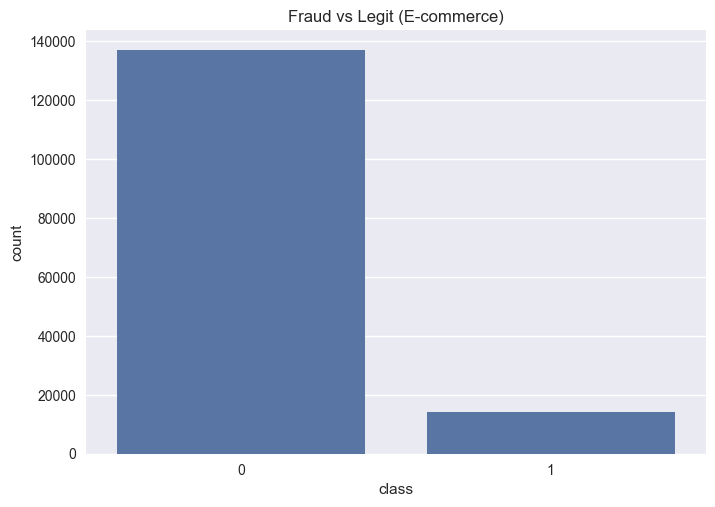

class
0    0.906354
1    0.093646
Name: proportion, dtype: float64


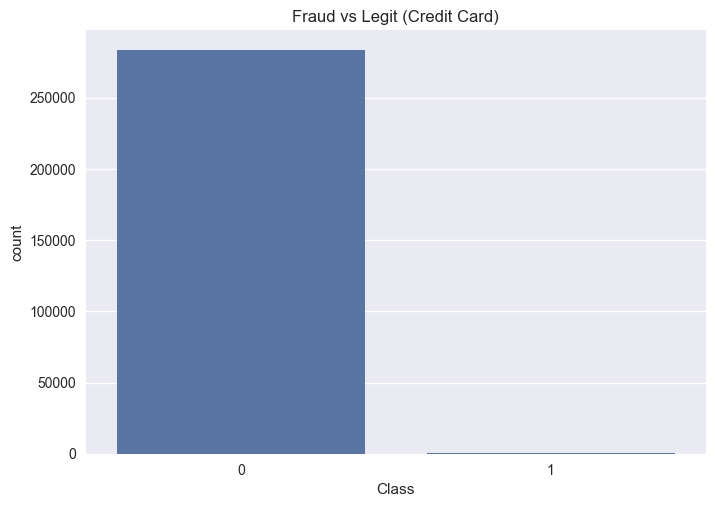

Class
0    0.998333
1    0.001667
Name: proportion, dtype: float64


In [8]:
# E-commerce fraud class counts
sns.countplot(x='class', data=fraud_df)
plt.title("Fraud vs Legit (E-commerce)")
plt.show()

print(fraud_df['class'].value_counts(normalize=True))

# Credit card class counts
sns.countplot(x='Class', data=credit_df)
plt.title("Fraud vs Legit (Credit Card)")
plt.show()

print(credit_df['Class'].value_counts(normalize=True))


### IP Geolocation Mapping

We will:
1. Convert IP to integer
2. Merge with IP mapping
3. Analyze by country


In [9]:
fraud_df['ip_num'] = pd.to_numeric(fraud_df['ip_address'], errors='coerce')
ip_map['lower'] = pd.to_numeric(ip_map['lower_bound_ip_address'], errors='coerce')
ip_map['upper'] = pd.to_numeric(ip_map['upper_bound_ip_address'], errors='coerce')
fraud_df = fraud_df.sort_values('ip_num')
ip_map = ip_map.sort_values('lower')
merged = pd.merge_asof(
    fraud_df,
    ip_map,
    left_on='ip_num',
    right_on='lower',
    direction='nearest'
)


print(merged[['ip_num','country','class']].head())


          ip_num    country  class
0   52093.496895  Australia      0
1   93447.138961  Australia      0
2  105818.501505  Australia      0
3  117566.664867  Australia      0
4  131423.789042  Australia      0


##1 — Calculate Fraud Metrics by Country

Once you have merged the geolocation info onto your transactions (fraud_df now contains a country column), start with simple aggregation:


Top 20 Countries by Fraud Rate:
                                   country  total_transactions  fraud_count  \
172                          Turkmenistan                   1            1   
38   Congo The Democratic Republic of The                  12           10   
26                      Brunei Darussalam                  17           10   
54                               Ethiopia                   3            1   
13                             Bangladesh                  76           23   
62                                Georgia                  60           18   
94                                Lebanon                  40           12   
126                                  Oman                  54           16   
86                                 Jordan                  46           13   
10                             Azerbaijan                  39           11   
132                                  Peru                 129           33   
40                          Co

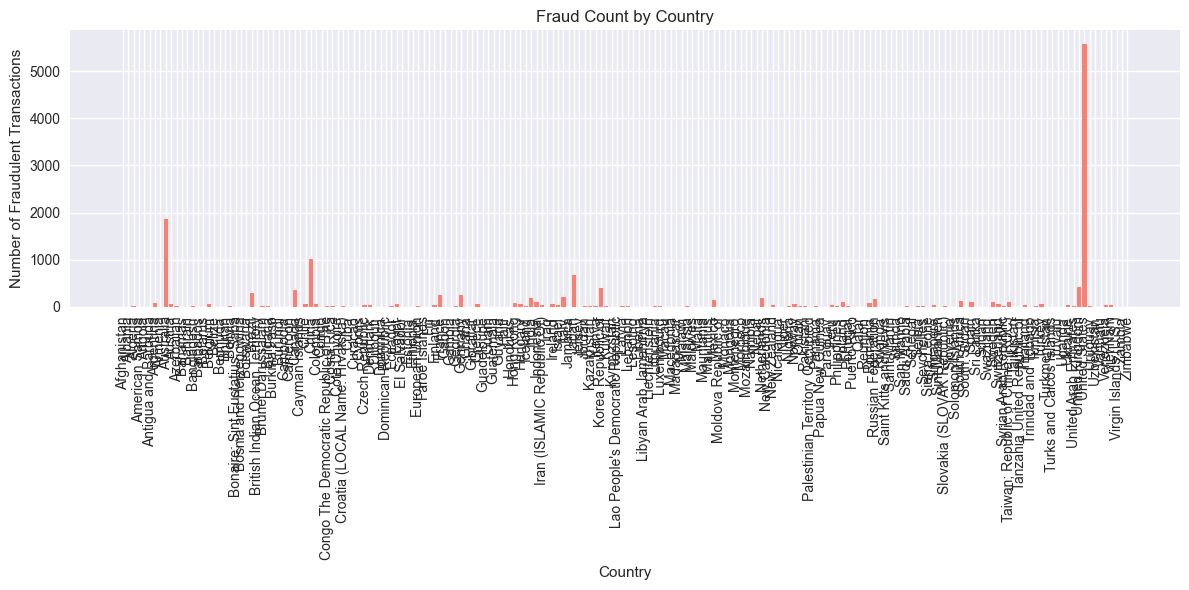

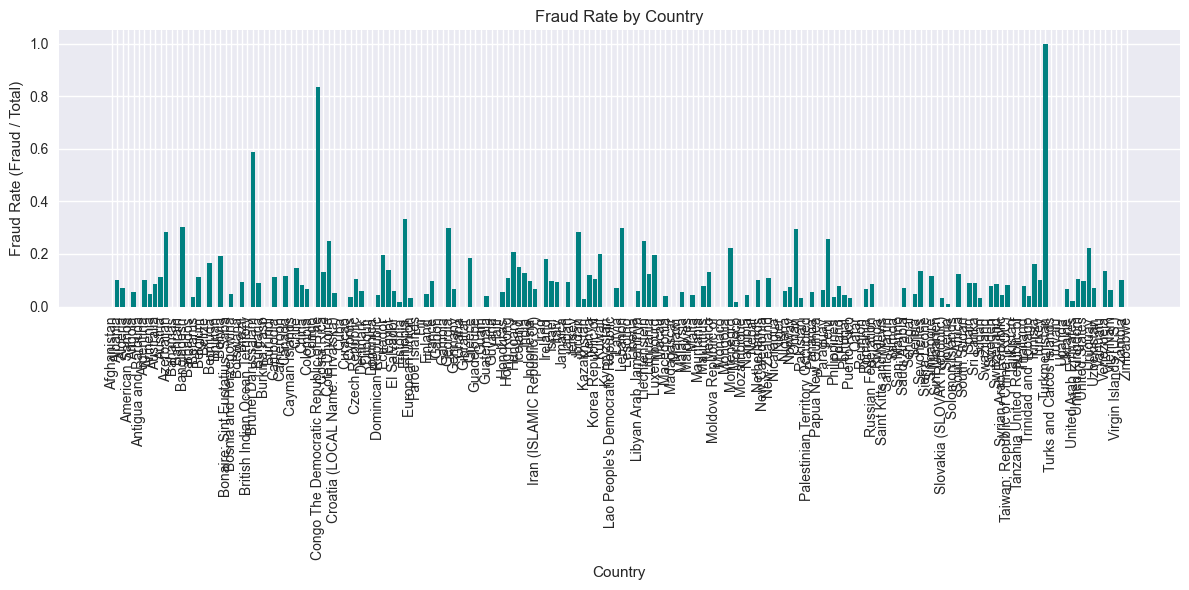

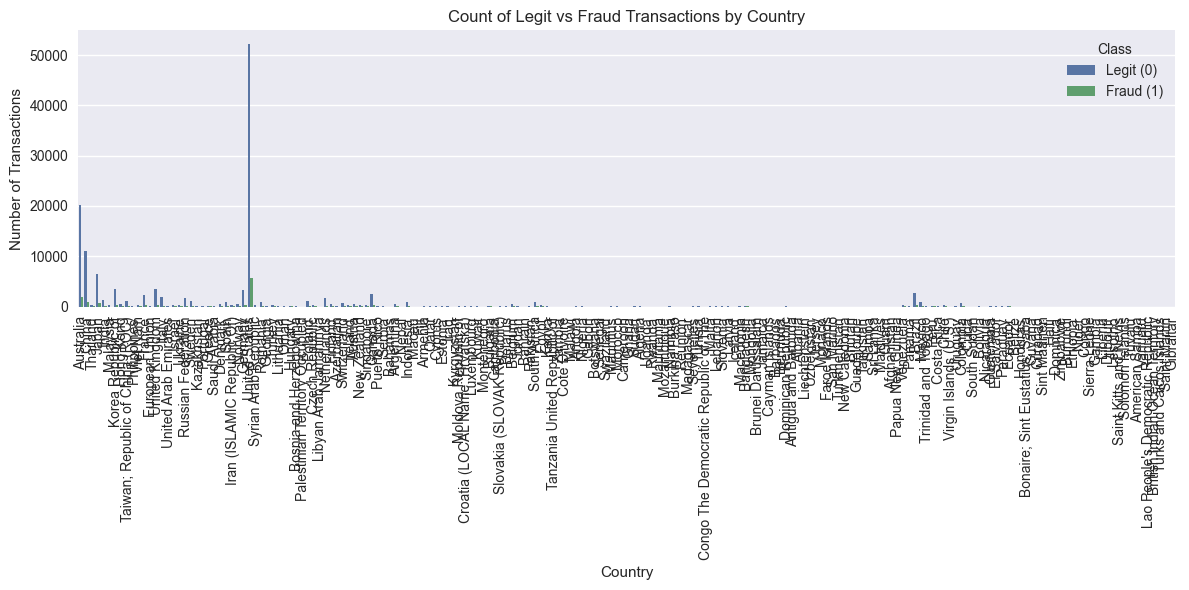


Chi-square statistic: 890.1108
p-value: 5.196e-92

Countries by Total Transactions:
                              country  total_transactions  fraud_count  \
179                    United States               57871         5591   
8                          Australia               22084         1866   
35                             China               12061         1002   
84                             Japan                7134          662   
178                   United Kingdom                3968          415   
89                 Korea Republic of                3849          404   
63                           Germany                3534          243   
24                            Brazil                2973          281   
32                            Canada                2938          347   
59                            France                2566          254   
82                             Italy                2126          199   
140               Russian Federation  

In [10]:
# -----------------------------
# Fraud by Country Analysis
# -----------------------------
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency

# 1) Compute total & fraud counts by country
country_stats = merged.groupby('country', as_index=False).agg(
    total_transactions=('class', 'count'),
    fraud_count=('class', 'sum')
)

country_stats['fraud_rate'] = country_stats['fraud_count'] / country_stats['total_transactions']

# Sort by fraud rate (descending) and show top 20
top_20 = country_stats.sort_values('fraud_rate', ascending=False).head(20)
print("\nTop 20 Countries by Fraud Rate:\n", top_20)

# 2) Bar chart: Fraud count by country
plt.figure(figsize=(12,6))
plt.bar(country_stats['country'], country_stats['fraud_count'], color='salmon')
plt.xticks(rotation=90)
plt.title("Fraud Count by Country")
plt.xlabel("Country")
plt.ylabel("Number of Fraudulent Transactions")
plt.tight_layout()
plt.show()

# 3) Bar chart: Fraud rate by country
plt.figure(figsize=(12,6))
plt.bar(country_stats['country'], country_stats['fraud_rate'], color='teal')
plt.xticks(rotation=90)
plt.title("Fraud Rate by Country")
plt.xlabel("Country")
plt.ylabel("Fraud Rate (Fraud / Total)")
plt.tight_layout()
plt.show()

# 4) Legit vs Fraud count per country
plt.figure(figsize=(12,6))
sns.countplot(x='country', hue='class', data=merged)
plt.xticks(rotation=90)
plt.title("Count of Legit vs Fraud Transactions by Country")
plt.xlabel("Country")
plt.ylabel("Number of Transactions")
plt.legend(title='Class', labels=['Legit (0)', 'Fraud (1)'])
plt.tight_layout()
plt.show()

# 5) Chi-square test for relationship between country and fraud
cont_table = pd.crosstab(merged['country'], merged['class'])
chi2, p, dof, ex = chi2_contingency(cont_table)

print(f"\nChi-square statistic: {chi2:.4f}")
print(f"p-value: {p:.4g}")

# Optional: show countries sorted by total_transactions
print("\nCountries by Total Transactions:\n", country_stats.sort_values('total_transactions', ascending=False).head(20))


##Save the processed data

In [13]:
# -----------------------------------------
# SAVE "merged" DATAFRAME TO PROCESSED FOLDER
# -----------------------------------------

import os

# Ensure the processed folder exists
processed_path = "../data/processed"
os.makedirs(processed_path, exist_ok=True)

# Drop repeated/unnecessary columns before saving
columns_to_drop = ["ip_address", "lower_bound_ip_address", "upper_bound_ip_address"]
merged = merged.drop(columns=columns_to_drop, errors="ignore")

# Save merged data
processed_file = os.path.join(processed_path, "fraud_data_with_country.csv")
merged.to_csv(processed_file, index=False)

print(f"✅ Processed file saved to: {processed_file}")



✅ Processed file saved to: ../data/processed\fraud_data_with_country.csv
